## 식중독 분석

### 1. 네이버 트랜드 & 환자수

In [2]:
import os
from dotenv import load_dotenv
import pandas as pd
import mysql.connector


# .env 파일 로드 (DB 정보)
load_dotenv()

# 환경 변수 읽기
DB_HOST = os.getenv("DB_HOST")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_NAME = os.getenv("DB_NAME")
DB_SUER = os.getenv("DB_USER")

In [17]:
conn = mysql.connector.connect(
    host = DB_HOST,
    user = DB_SUER,
    password = DB_PASSWORD,
    database = DB_NAME
)   

# 커서 객체 생성 (SQL 쿼리를 실행하고 결과를 가져오기 위해 사용)
cursor = conn.cursor(buffered=True)

# SQL 쿼리 실행 및 데이터 불러오기
query = """
SELECT report_date, food_poisoning FROM michelin.naver_trend_day
WHERE report_date BETWEEN '2019-01-01' AND '2024-12-31';
"""
df = pd.read_sql(query, conn)

# 연결 종료
conn.close()

df['report_date'] = pd.to_datetime(df['report_date'])  # 날짜 형식 변환
df['report_date'] = df['report_date'].dt.to_period('M')  # 년-월 추출


numeric_columns = df.select_dtypes(include=['number']).columns

df_numeric = df.groupby('report_date')[numeric_columns].sum()

print(df_numeric)


             food_poisoning
report_date                
2019-01           420.36460
2019-02           365.54810
2019-03           339.53027
2019-04           368.27894
2019-05           482.48670
...                     ...
2024-01           605.91470
2024-02           476.62210
2024-03           396.78570
2024-04           401.68270
2024-05           486.05360

[65 rows x 1 columns]


/tmp/ipykernel_21407/110981230.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [18]:
conn = mysql.connector.connect(
    host = DB_HOST,
    user = DB_SUER,
    password = DB_PASSWORD,
    database = DB_NAME
)   

cursor = conn.cursor(buffered=True)

# SQL 쿼리 실행 및 데이터 불러오기
# SQL 쿼리 작성: 'michelin.disease_age' 테이블에서 'age_group_10'이 "계"이고 'category'가 "식중독 관련 감염병"인 데이터 선택
# 날짜는 'YYYY-MM' 형식으로 변환하고, 'patient_count'는 100으로 나누어 변환

query = """
SELECT DATE_FORMAT(report_date, '%Y-%m') as report_date, patient_count / 100 as patient_count 
FROM michelin.disease_age where age_group_10 = "계" and category = "식중독 관련 감염병";
"""
df_poison_patients = pd.read_sql(query, conn)
df_poison_patients.set_index("report_date", inplace=True)

# 연결 종료
conn.close()

/tmp/ipykernel_21407/833779335.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_poison_patients = pd.read_sql(query, conn)


In [43]:
df_poison_patients

,patient_count
report_date,
2019-01,108655
2019-02,87769
2019-03,87083
2019-04,91450
2019-05,99044
...,...
2024-01,129623
2024-02,101367
2024-03,94775


In [44]:
df_numeric

,temperature_range
report_date,
2019-01,4961.2
2019-02,4426.7
2019-03,5553.7
2019-04,5222.7
2019-05,6279.0
...,...
2024-08,4322.1
2024-09,4229.2
2024-10,4625.9


In [21]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# 'food_poisoning' 컬럼의 데이터를 0과 1 사이로 정규화 (스케일링)
df_numeric['food_poisoning'] = scaler.fit_transform(df_numeric[['food_poisoning']])

# 'food_poisoning' 컬럼의 데이터를 다시 'patient_count' 범위로 되돌림
# patient_count의 최소값과 최대값을 사용하여 정규화된 값을 다시 원래의 범위로 변환
df_numeric['food_poisoning'] = df_numeric['food_poisoning'] * (df_poison_patients['patient_count'].max() - df_poison_patients['patient_count'].min()) + df_poison_patients['patient_count'].min()

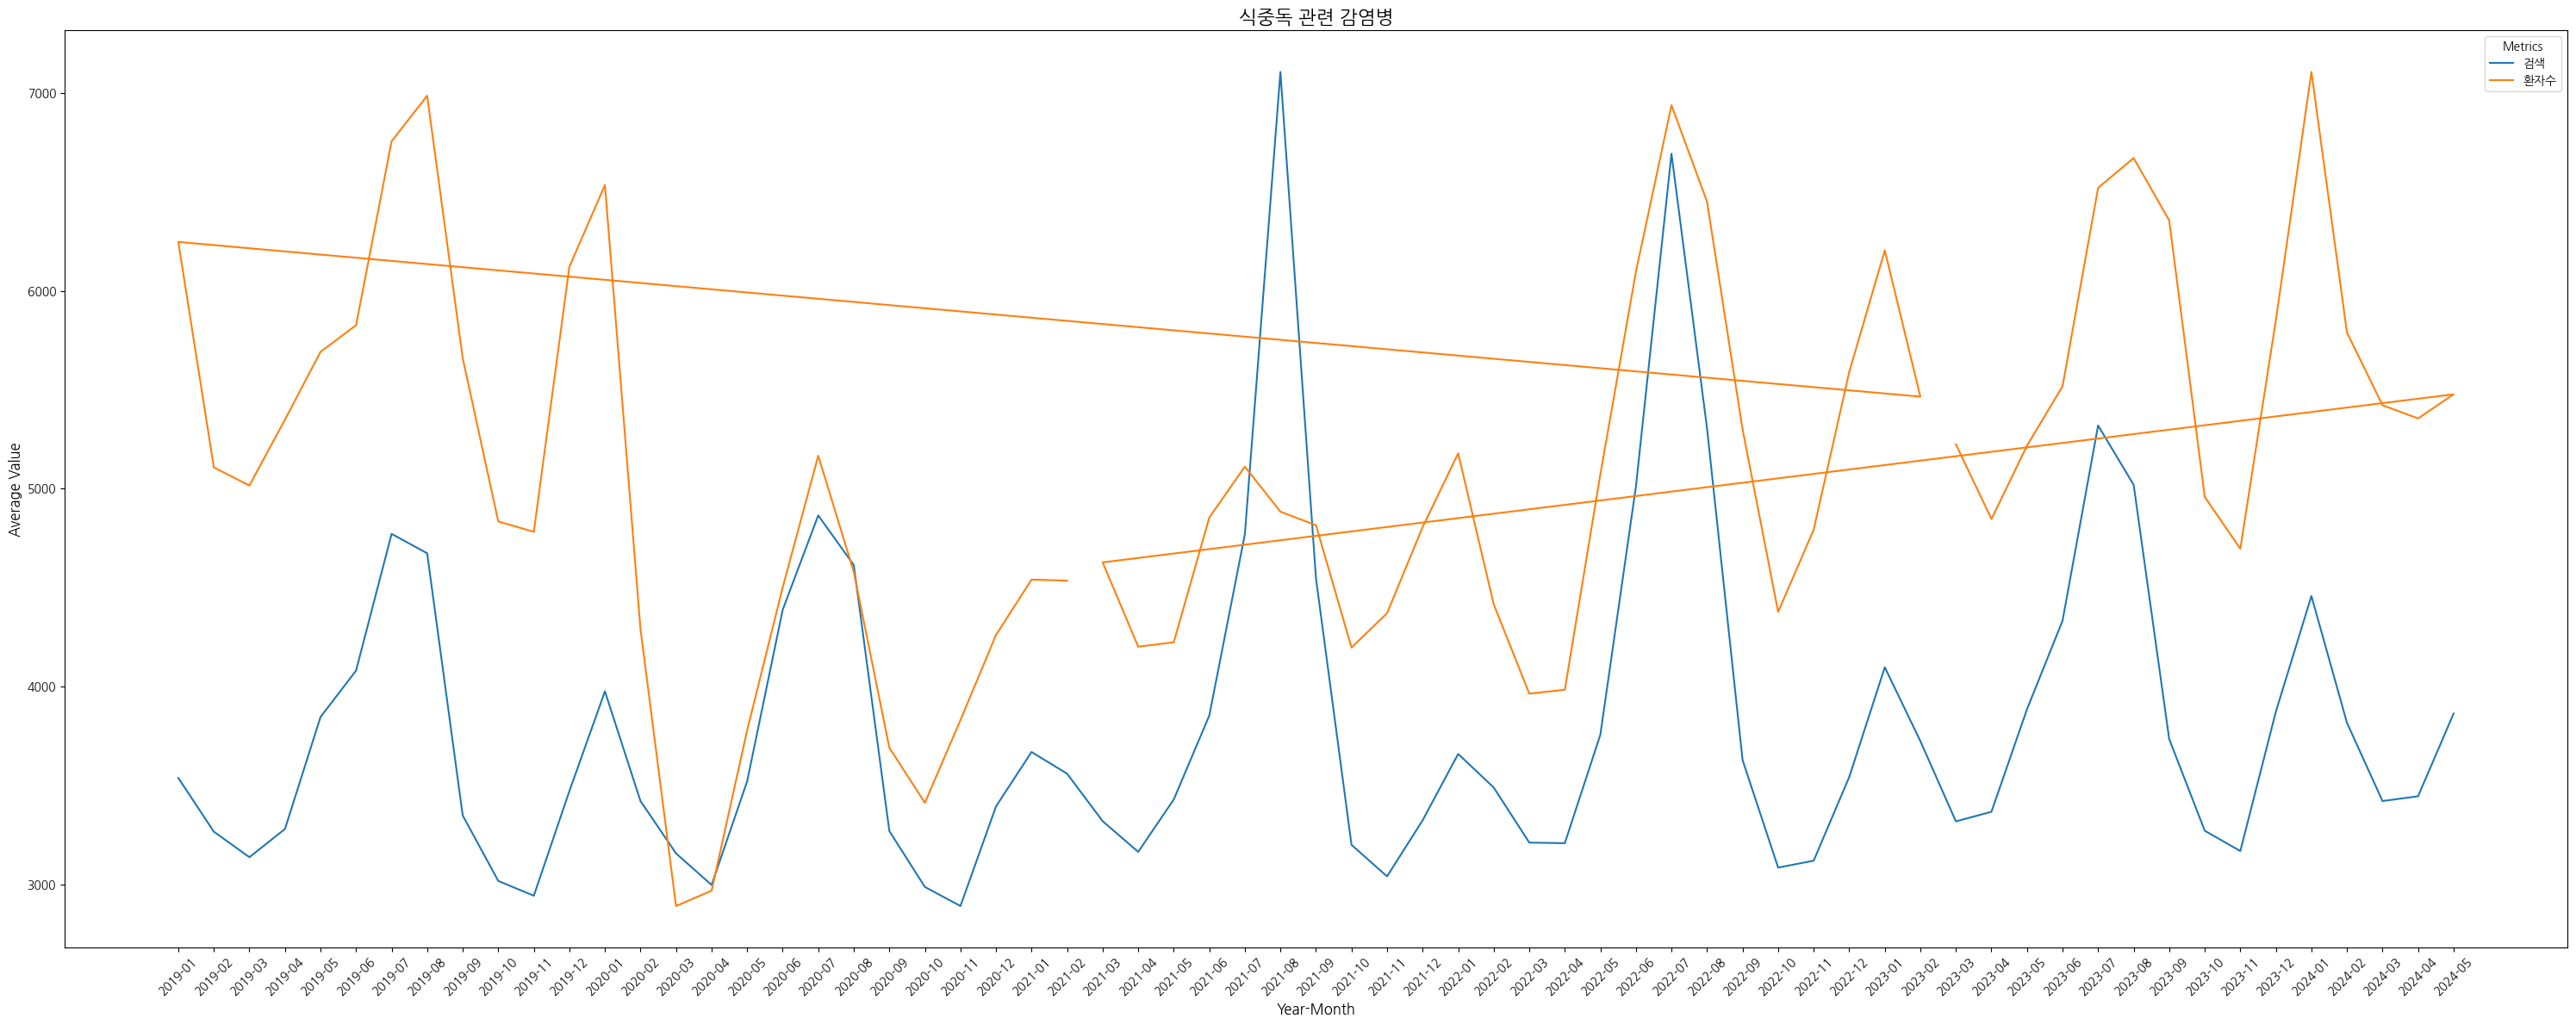

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

plt.figure(figsize=(30, 12))
plt.plot(df_numeric.index.astype(str), df_numeric["food_poisoning"], label=("검색"))
plt.plot(df_poison_patients.index.astype(str), df_poison_patients["patient_count"], label=("환자수"))

plt.title("식중독 관련 감염병", fontsize=16)
plt.xlabel("Year-Month", fontsize=12)
plt.ylabel("Average Value", fontsize=12)
plt.legend(title="Metrics")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 2. 일교차와의 상관관계

In [25]:
import os
from dotenv import load_dotenv
import pandas as pd
import mysql.connector


# .env 파일 로드 (DB 정보)
load_dotenv()

# 환경 변수 읽기
DB_HOST = os.getenv("DB_HOST")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_NAME = os.getenv("DB_NAME")
DB_SUER = os.getenv("DB_USER")

In [41]:
# 날씨 일자, 일교차 가져오기

conn = mysql.connector.connect(
    host = DB_HOST,
    user = DB_SUER,
    password = DB_PASSWORD,
    database = DB_NAME
)   

# 커서 객체 생성 (SQL 쿼리를 실행하고 결과를 가져오기 위해 사용)
cursor = conn.cursor(buffered=True)

# SQL 쿼리 실행 및 데이터 불러오기
# 서울만 가져온거임
query = """
SELECT report_date, region, temperature_range FROM michelin.weather_temperature
WHERE (report_date BETWEEN '2019-01-01' AND '2024-12-30') AND (region='서울');
"""
df = pd.read_sql(query, conn)

# 연결 종료
conn.close()

# 'report_date' 컬럼을 날짜 형식으로 변환
df['report_date'] = pd.to_datetime(df['report_date'])

df['month'] = df['report_date'].dt.to_period('M')

# 월별 평균 일교차 계산
seoul_monthly_avg_temp_range = df.groupby('month')['temperature_range'].mean()
seoul_monthly_avg_temp_range = seoul_monthly_avg_temp_range.reset_index()
seoul_monthly_avg_temp_range.columns = ['months', 'avg_range']


# 결과 출력
seoul_monthly_avg_temp_range


/tmp/ipykernel_21407/1143590714.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,months,avg_range
0,2019-01,9.151613
1,2019-02,9.264286
2,2019-03,9.700000
3,2019-04,10.463333
4,2019-05,11.912903
...,...,...
67,2024-08,7.048387
68,2024-09,7.850000
69,2024-10,8.735484
70,2024-11,9.423333


In [38]:
conn = mysql.connector.connect(
    host = DB_HOST,
    user = DB_SUER,
    password = DB_PASSWORD,
    database = DB_NAME
)   

cursor = conn.cursor(buffered=True)

# SQL 쿼리 실행 및 데이터 불러오기
# SQL 쿼리 작성: 'michelin.disease_age' 테이블에서 'age_group_10'이 "계"이고 'category'가 "식중독 관련 감염병"인 데이터 선택
# 날짜는 'YYYY-MM' 형식으로 변환하고, 'patient_count'는 100으로 나누어 변환

query = """
SELECT DATE_FORMAT(report_date, '%Y-%m') as report_date, patient_count as patient_count 
FROM michelin.disease_do 
WHERE region = "서울" and category = "식중독 관련 감염병";
"""
df_poison_patients = pd.read_sql(query, conn)
df_poison_patients.set_index("report_date", inplace=True)

# 연결 종료
conn.close()

/tmp/ipykernel_21407/1189910356.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_poison_patients = pd.read_sql(query, conn)


In [49]:
pd.set_option('display.max_rows', None)
df_poison_patients

,patient_count
report_date,
2019-01,108655
2019-02,87769
2019-03,87083
2019-04,91450
2019-05,99044
2019-06,102596
2019-07,123763
2019-08,124864
2019-09,96736


In [50]:
pd.set_option('display.max_rows', None)

seoul_monthly_avg_temp_range

,months,avg_range
0,2019-01,9.151613
1,2019-02,9.264286
2,2019-03,9.700000
3,2019-04,10.463333
4,2019-05,11.912903
5,2019-06,9.646667
6,2019-07,7.403226
7,2019-08,8.045161
8,2019-09,8.136667
9,2019-10,9.967742


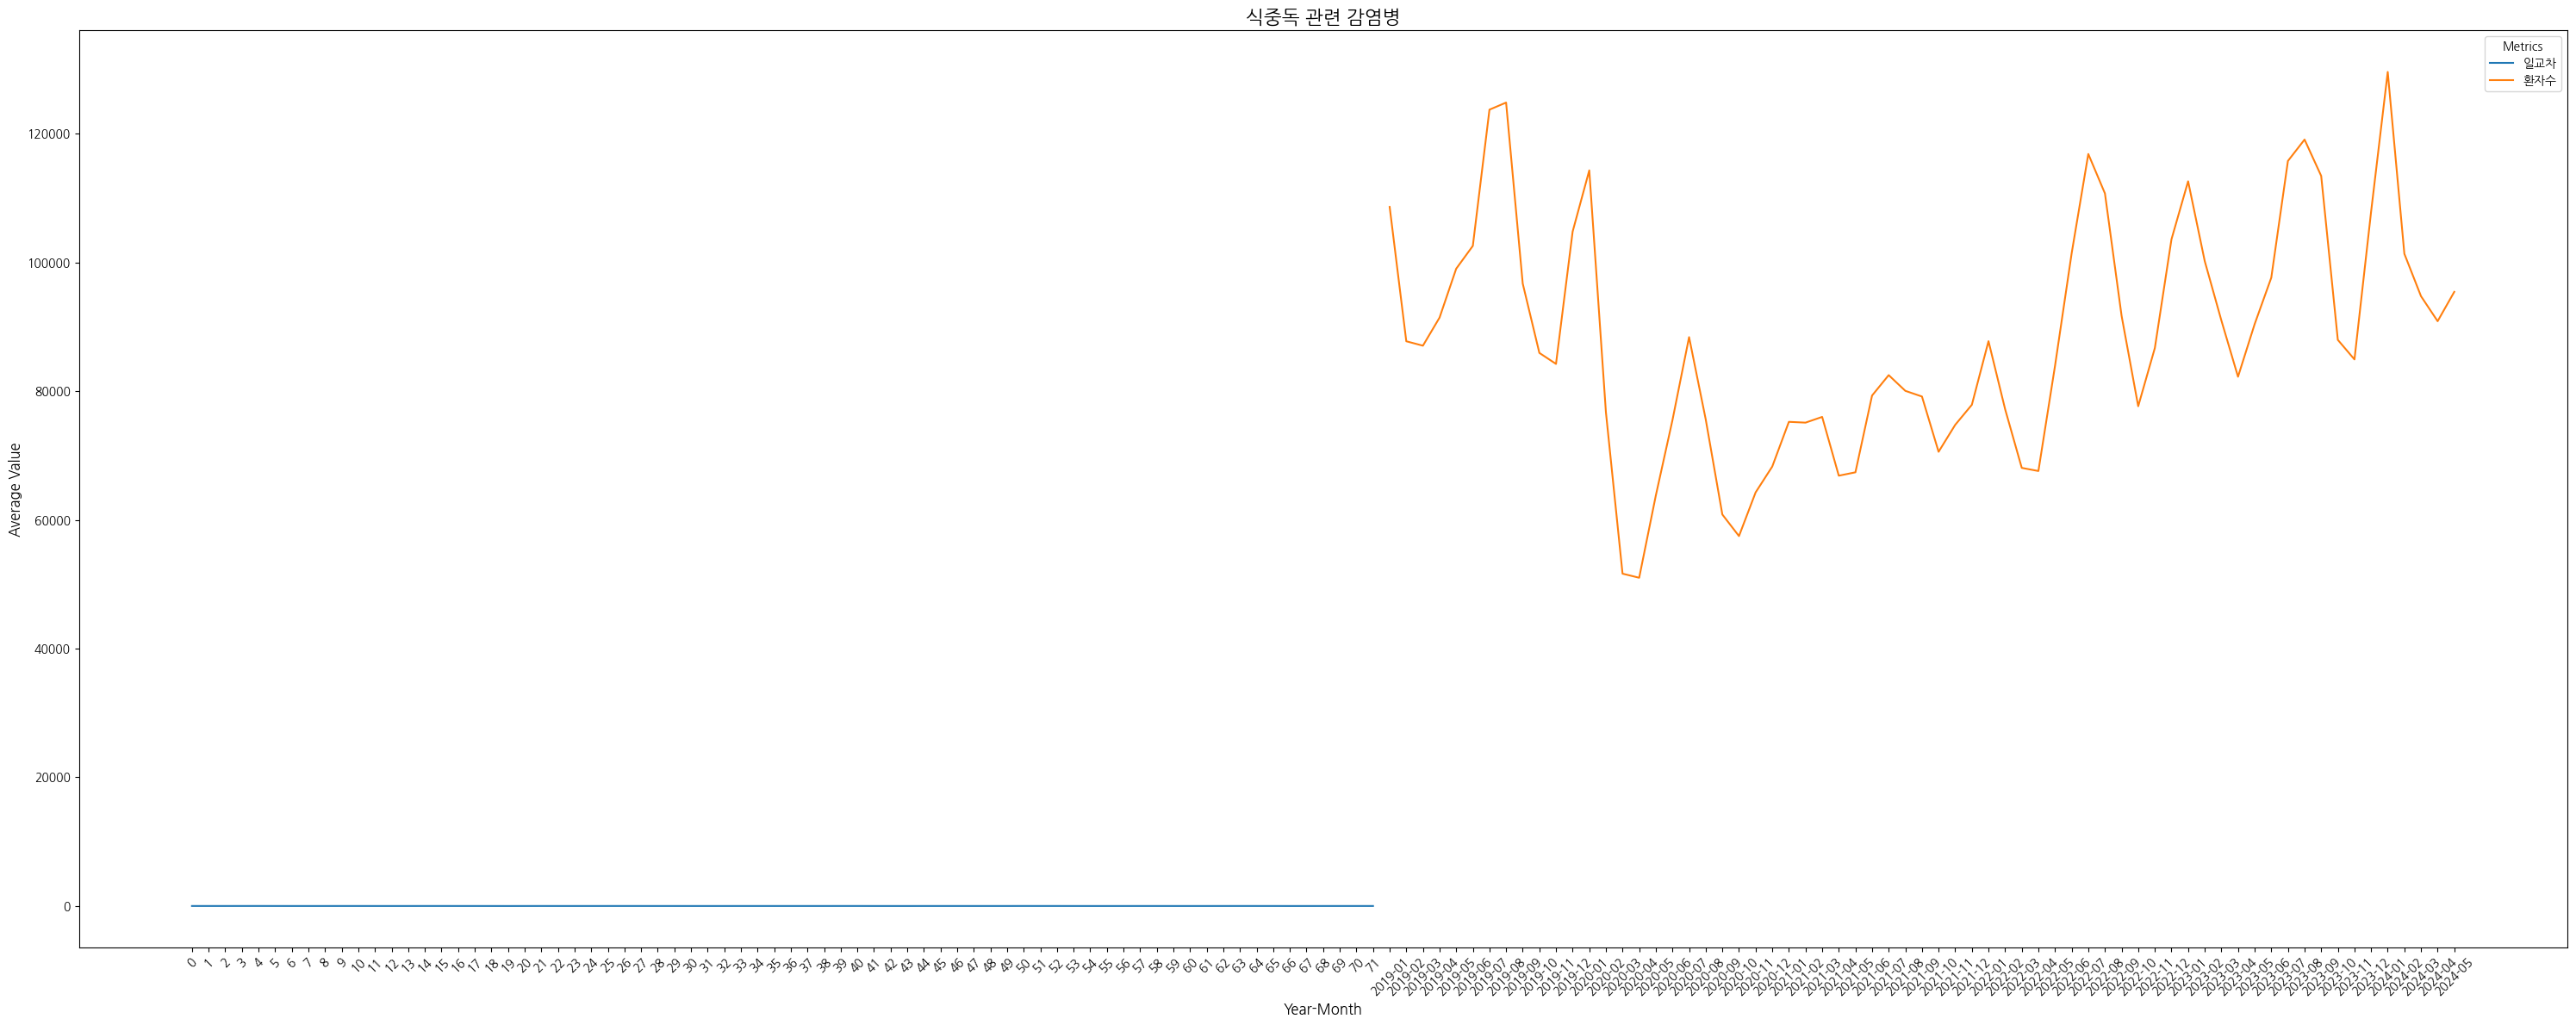

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

plt.figure(figsize=(30, 12))
plt.plot(seoul_monthly_avg_temp_range.index.astype(str), seoul_monthly_avg_temp_range["avg_range"], label=("일교차"))
plt.plot(df_poison_patients.index.astype(str), df_poison_patients["patient_count"], label=("환자수"))

plt.title("식중독 관련 감염병", fontsize=16)
plt.xlabel("Year-Month", fontsize=12)
plt.ylabel("Average Value", fontsize=12)
plt.legend(title="Metrics")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()